# 03 - Bayesian Hierarchical Modeling

Fit hierarchical model to 911 prices, diagnose, visualize, and predict.

**Inputs:**
- `data/processed/cleaned_listings.parquet`

**Model:**
```
log(price) ~ age + mileage + 
             (1 + age | generation) +  # random intercept + slope
             (1 | trim_tier) +         # collapsed: base, sport, gt, turbo
             (1 | transmission)
```

**Fixes for convergence:**
1. Weakly informative priors on random effect SDs (HalfNormal σ=0.3-0.5)
2. Trim collapsed into 4 tiers (sparse individual levels)
3. Higher target_accept (0.95)

In [1]:
import logging
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from price_analysis.data.cleaning import prepare_model_data
from price_analysis.models import build_model, fit_model, predict_price
from price_analysis.models.hierarchical import (
    DEFAULT_RE_PRIORS,
    check_diagnostics,
    extract_effects,
    format_prediction_summary,
)
from price_analysis.visualization import plot_prior_posterior, plot_shrinkage_regression

logging.basicConfig(level=logging.INFO)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Paths
DATA_DIR = Path("../data")
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_listings.parquet"

## Load and Prepare Data

In [3]:
df_cleaned = pd.read_parquet(PROCESSED_PATH)
df = prepare_model_data(df_cleaned, group_trims=True, group_trans=True)

# Scaling parameters for prediction
MILEAGE_MEAN, MILEAGE_STD = df_cleaned["mileage"].mean(), df_cleaned["mileage"].std()

print(
    f"Model data: {len(df)} listings | Mileage scaling: μ={MILEAGE_MEAN:.0f}, σ={MILEAGE_STD:.0f}"
)
print(f"Trim tiers: {df['trim_tier'].value_counts().to_dict()}")
print(f"Trans types: {df['trans_type'].value_counts().to_dict()}")

INFO:price_analysis.data.cleaning:Grouped trims into tiers: {'base': 449, 'sport': 387, 'turbo': 264, 'gt': 141, 'rs': 83}
INFO:price_analysis.data.cleaning:Grouped transmissions into types: {'manual': 774, 'pdk': 456, 'auto': 94}
INFO:price_analysis.data.cleaning:Model-ready dataset: 1324 listings (from 1559 cleaned)


Model data: 1324 listings | Mileage scaling: μ=40452, σ=38240
Trim tiers: {'base': 449, 'sport': 387, 'turbo': 264, 'gt': 141, 'rs': 83}
Trans types: {'manual': 774, 'pdk': 456, 'auto': 94}


In [4]:
# Model configuration
INCLUDE_SALE_YEAR = False  # Currently all 2025 listings (no variance)
USE_TRIM_TIER = True  # Collapse trims into 4 performance tiers
USE_TRANS_TYPE = True  # Collapse Auto/Tiptronic into 'auto'
TARGET_ACCEPT = 0.95  # Higher acceptance rate to reduce divergences

# Show default priors (can override with custom dict)
print("Default random effect SD priors (HalfNormal sigma):")
for k, v in DEFAULT_RE_PRIORS.items():
    print(f"  {k}: {v}")

Default random effect SD priors (HalfNormal sigma):
  generation_sd: 0.5
  trim_sd: 0.5
  transmission_sd: 0.3
  age_slope_sd: 0.1


In [5]:
# Complex model with random slopes on age by generation (for comparison)
model_with_slope = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,  # Random slope on age
    use_trim_tier=USE_TRIM_TIER,
    use_trans_type=USE_TRANS_TYPE,
)
print(model_with_slope)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type)
INFO:price_analysis.models.hierarchical:Built model with 1324 observations


       Formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type)
        Family: gaussian
          Link: mu = identity
  Observations: 1324
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3348, sigma: 4.2247)
            age ~ Normal(mu: 0.0, sigma: 0.2539)
            mileage_scaled ~ Normal(mu: 0.0, sigma: 2.1789)
            is_low_mileage ~ Normal(mu: 0.0, sigma: 4.7624)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.1))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8207)


In [6]:
# Fit complex model (this may take a few minutes)
idata_with_slope = fit_model(
    model_with_slope,
    draws=2000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 2000 draws, 1000 tune, 8 chains, target_accept=0.95
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset]


Output()

Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 82 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 82 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['1|', 'age|'] have not been found and will be ignored
  warnings.warn(
INFO:price_analysis.models.hierarchical:Model summary:
                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma                   0.234  0.005   0.225    0.242      0.000    0.000   
Intercept              12.005  0.276  11.471   12.524      0.004    0.004   
age                    -0.041  0.007  -0.052   -0.028      0.000    0.

## Model Comparison: With vs Without Age Slopes by Generation

The forest plot above shows `age|generation` effects clustered at zero with tight CIs.
Let's formally test whether random slopes on age add predictive value using LOO-CV.

In [7]:
# Primary model: intercept-only for generation (simpler, preferred)
model = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=False,  # No random slope on age (LOO-CV preferred)
    use_trim_tier=USE_TRIM_TIER,
    use_trans_type=USE_TRANS_TYPE,
)
print(model)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 | generation) + (1 | trim_tier) + (1 | trans_type)
INFO:price_analysis.models.hierarchical:Built model with 1324 observations


       Formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 | generation) + (1 | trim_tier) + (1 | trans_type)
        Family: gaussian
          Link: mu = identity
  Observations: 1324
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3348, sigma: 4.2247)
            age ~ Normal(mu: 0.0, sigma: 0.2539)
            mileage_scaled ~ Normal(mu: 0.0, sigma: 2.1789)
            is_low_mileage ~ Normal(mu: 0.0, sigma: 4.7624)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8207)


In [8]:
# Fit primary model
idata = fit_model(
    model,
    draws=2000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 2000 draws, 1000 tune, 8 chains, target_accept=0.95
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset]


Output()

Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 72 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 72 seconds.
/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['1|', 'age|'] have not been found and will be ignored
  warnings.warn(
INFO:price_analysis.models.hierarchical:Model summary:
                        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma                  0.234  0.005   0.225    0.242      0.000    0.000   
Intercept             12.011  0.280  11.485   12.547      0.004    0.003   
age                   -0.043  0.006  -0.053   -0.032      0.000    0.000   
mileage_scaled        -0.223  0.010  -0.242   -0.205      0.000    0.000   
is_low_mileage         0.168  0.024   0.123    0.213      0.000    0.000   
1|generation_sigma     0.134  0.062   0.

In [9]:
# Compare models via PSIS-LOO
# (log_likelihood computed during fitting via idata_kwargs)
comparison = az.compare(
    {"with_age_slope": idata_with_slope, "intercept_only": idata},
    ic="loo",
    scale="log",
)
display(comparison.round(4))

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
with_age_slope,0,36.6127,21.0505,0.0000,0.8759,41.3296,0.0000,False,log
intercept_only,1,36.3185,20.6574,0.2942,0.1241,41.3562,0.8853,False,log


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/323549480.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


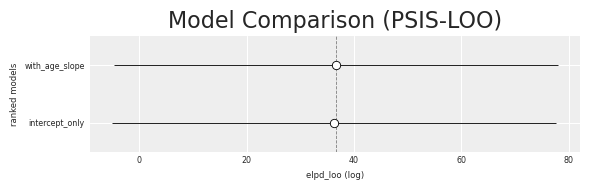

In [10]:
# Visualize model comparison
az.plot_compare(comparison)
plt.title("Model Comparison (PSIS-LOO)")
plt.tight_layout()
plt.show()

In [11]:
# Compare diagnostics
diag_with_slope = check_diagnostics(idata_with_slope)
diag_primary = check_diagnostics(idata)

print("Model with age slope:")
print(f"  Divergences: {diag_with_slope['n_divergences']}")
print(f"  Max R-hat: {diag_with_slope['rhat_max']:.4f}")
print(f"  Min ESS (bulk): {diag_with_slope['ess_bulk_min']:.0f}")

print("\nPrimary model (intercept only):")
print(f"  Divergences: {diag_primary['n_divergences']}")
print(f"  Max R-hat: {diag_primary['rhat_max']:.4f}")
print(f"  Min ESS (bulk): {diag_primary['ess_bulk_min']:.0f}")

Model with age slope:
  Divergences: 5
  Max R-hat: 1.0000
  Min ESS (bulk): 3668

Primary model (intercept only):
  Divergences: 0
  Max R-hat: 1.0000
  Min ESS (bulk): 4524


### Interpretation

**LOO-CV comparison:**
- Higher ELPD = better out-of-sample predictive performance
- If difference < 1 SE, models are practically equivalent → prefer simpler
- `p_loo` = effective number of parameters (complexity penalty)

**Decision rule:** If `intercept_only` ELPD is within ~1 SE of `with_age_slope`, drop the random slope.

## MCMC Diagnostics

Check for convergence issues before interpreting results.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/3320152081.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


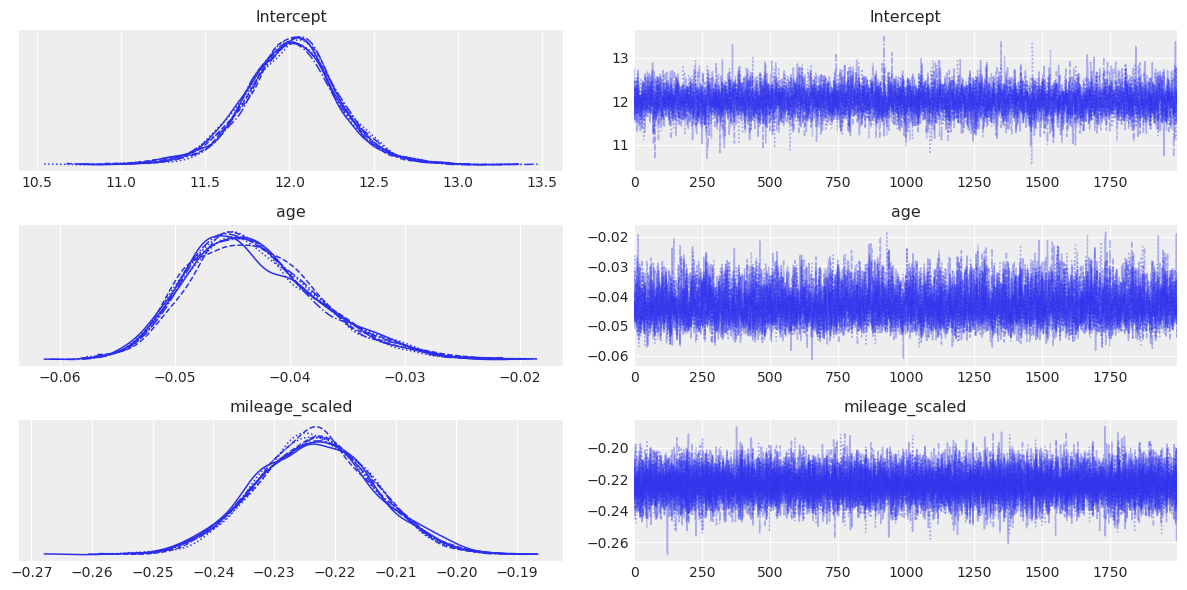

In [12]:
# Trace plots for fixed effects
var_names = ["Intercept", "age", "mileage_scaled"]
if INCLUDE_SALE_YEAR:
    var_names.append("sale_year")
az.plot_trace(idata, var_names=var_names)
plt.tight_layout()
plt.show()

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/3564994746.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


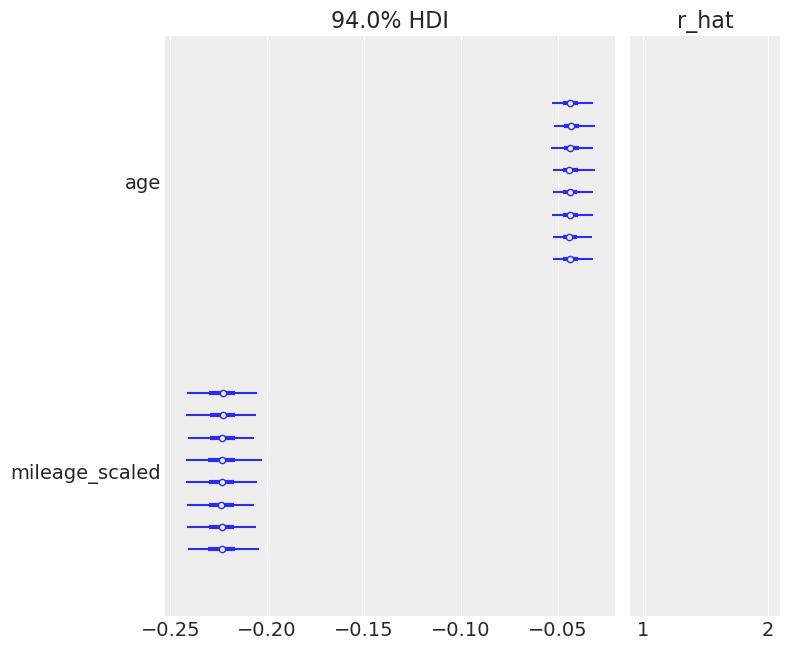

In [13]:
# R-hat summary
az.plot_forest(idata, var_names=["age", "mileage_scaled"], r_hat=True)
plt.tight_layout()
plt.show()

In [14]:
summary = az.summary(idata, var_names=var_names, hdi_prob=0.95)
display(summary)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,12.011,0.280,11.431,12.550,0.004,0.003,6035.0,8073.0,1.0
age,-0.043,0.006,-0.053,-0.031,0.000,0.000,6127.0,9754.0,1.0
mileage_scaled,-0.223,0.010,-0.241,-0.204,0.000,0.000,21860.0,11413.0,1.0


**Interpretation (coefficients are on log-price scale):**

- `age`: Expected change in log(price) per year of age (negative = depreciation)
- `mileage_scaled`: Effect of 1 SD increase in mileage
- `sale_year`: Market trend (positive = prices rising over time) — *excluded when constant*

## Random Effects

Visualize generation, trim, and transmission effects.

In [15]:
effects = extract_effects(idata)

print("Fixed effects:")
for name, vals in effects["fixed"].items():
    print(f"  {name}: {vals['mean']:.3f} [{vals['hdi_90'][0]:.3f}, {vals['hdi_90'][1]:.3f}]")

Fixed effects:
  Intercept: 12.011 [11.540, 12.448]
  age: -0.043 [-0.052, -0.034]
  mileage_scaled: -0.223 [-0.239, -0.207]


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/1072741184.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


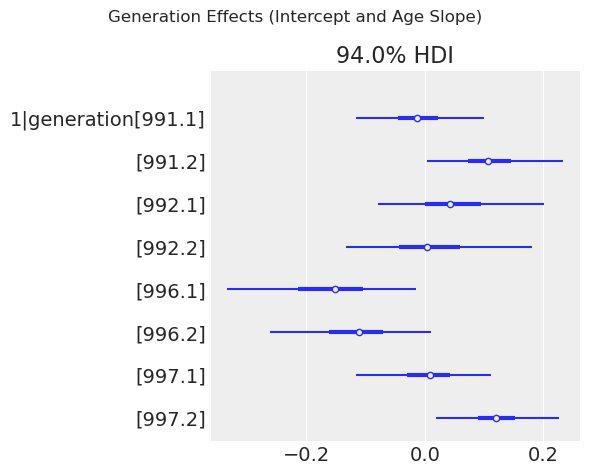

In [16]:
# Forest plot of generation effects
az.plot_forest(idata, var_names=["1|generation"], combined=True)
plt.suptitle("Generation Effects (Intercept and Age Slope)")
plt.tight_layout()
plt.show()

# , "age|generation"  # we rm'ed this effect, no real age x gen effect

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/1161933721.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


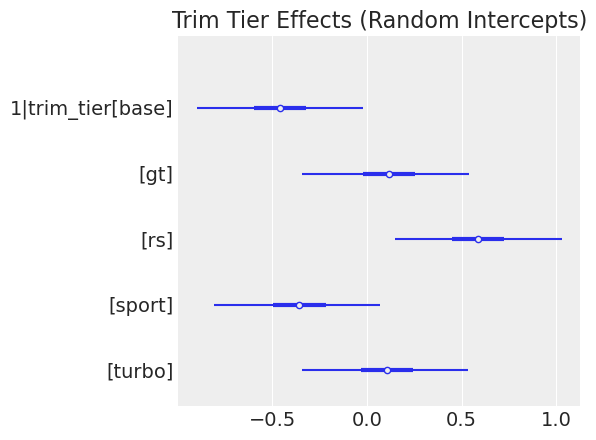

In [17]:
# Forest plot of trim tier effects
az.plot_forest(idata, var_names=["1|trim_tier"], combined=True)
plt.title("Trim Tier Effects (Random Intercepts)")
plt.tight_layout()
plt.show()

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/1451782903.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


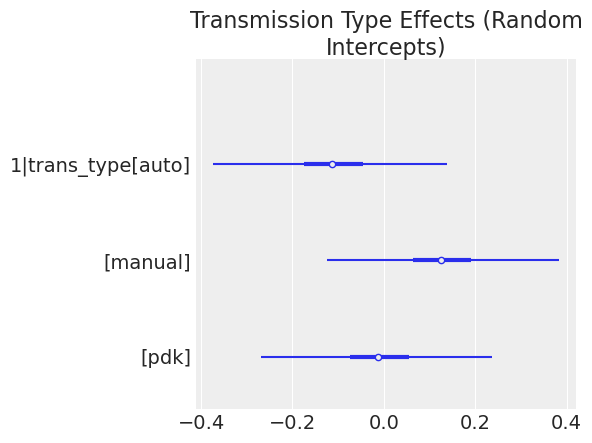

In [18]:
# Forest plot of transmission type effects
az.plot_forest(idata, var_names=["1|trans_type"], combined=True)
plt.title("Transmission Type Effects (Random Intercepts)")
plt.tight_layout()
plt.show()

## Posterior Predictive Checks

How well does the model reproduce the observed data?

In [19]:
# Generate posterior predictive samples
model.predict(idata, kind="response", inplace=True)

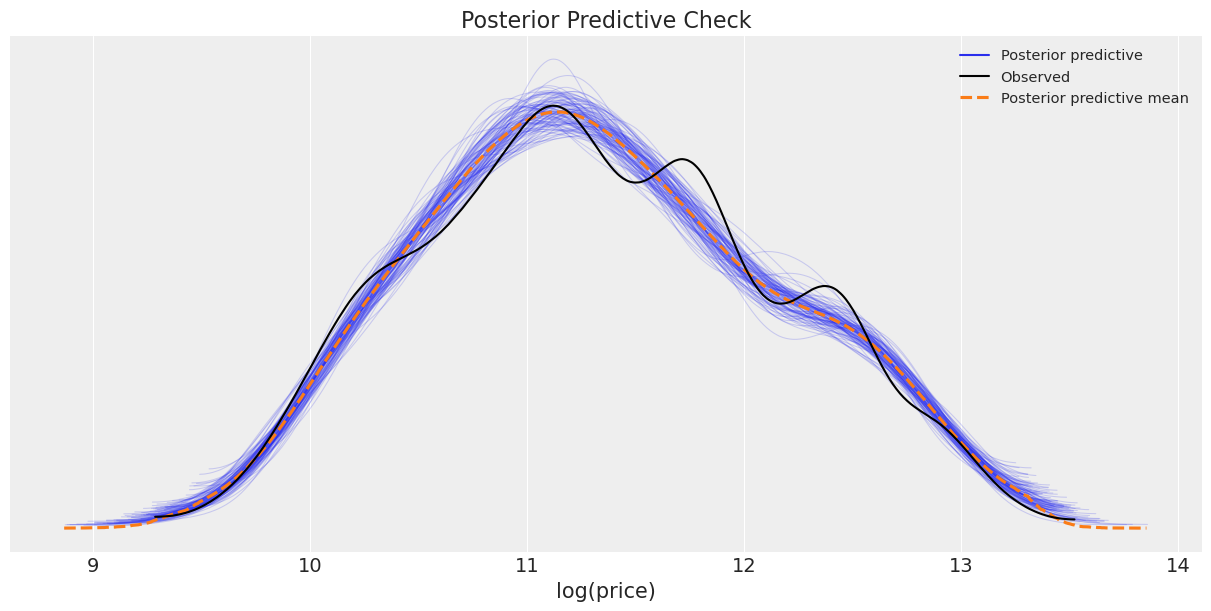

In [20]:
az.plot_ppc(idata, num_pp_samples=100)
plt.title("Posterior Predictive Check")
plt.xlabel("log(price)")
# plt.tight_layout()
plt.show()

## Price Predictions

Predict prices for specific configurations.

In [21]:
# Example estimate of price
pred = predict_price(
    model=model,
    idata=idata,
    generation="996.2",
    trim="Carrera 4S",  # for display
    trim_tier="sport",  # model uses tier
    transmission="Manual",  # for display
    trans_type="manual",  # model uses type
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
)

print(format_prediction_summary(pred))

Price prediction for:
  2002 996.2 Carrera 4S (Manual)
  Mileage: 45,000 miles
  Sale year: 2025 (age: 23 years)

Predicted price:
  Median: $41,795
  Mean:   $43,028
  80% CI: $30,954 - $56,470
  95% CI: $26,535 - $66,235


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/4107347789.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


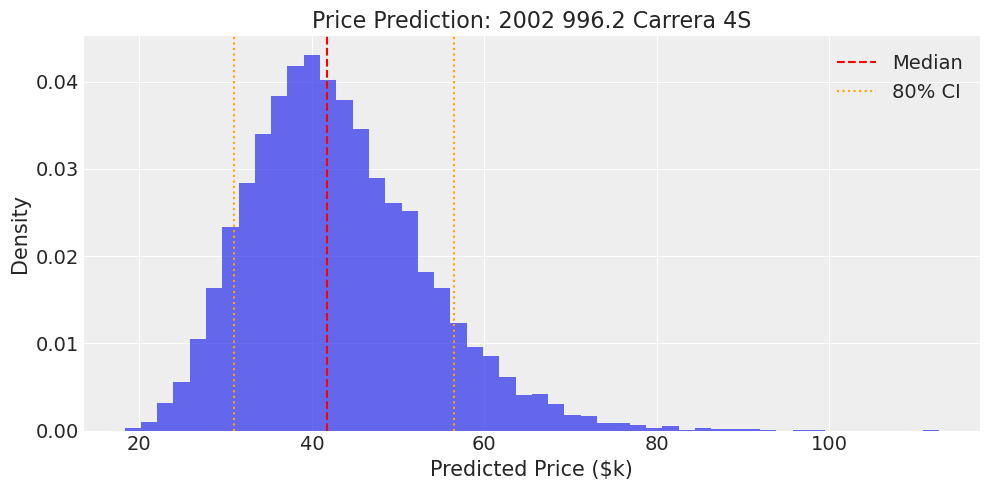

In [22]:
# Visualize prediction distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(pred["samples"] / 1000, bins=50, alpha=0.7, density=True)
ax.axvline(pred["price"]["median"] / 1000, color="red", linestyle="--", label="Median")
ax.axvline(pred["price"]["ci_80"][0] / 1000, color="orange", linestyle=":", label="80% CI")
ax.axvline(pred["price"]["ci_80"][1] / 1000, color="orange", linestyle=":")
ax.set_xlabel("Predicted Price ($k)")
ax.set_ylabel("Density")
ax.set_title(
    f"Price Prediction: {pred['config']['model_year']} {pred['config']['generation']} {pred['config']['trim']}"
)
ax.legend()
plt.tight_layout()
plt.show()

In [23]:
# Compare: Same car but different generation
pred_992 = predict_price(
    model=model,
    idata=idata,
    generation="992.1",
    trim="Carrera 4S",
    trim_tier="sport",
    transmission="PDK",
    trans_type="pdk",
    model_year=2022,
    mileage=45000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
)

print("996.2 vs 992.1 Carrera 4S comparison:")
print(f"  996.2 (2002, 45k mi, Manual): ${pred['price']['median']:,.0f}")
print(f"  992.1 (2022, 45k mi, PDK):    ${pred_992['price']['median']:,.0f}")

996.2 vs 992.1 Carrera 4S comparison:
  996.2 (2002, 45k mi, Manual): $41,795
  992.1 (2022, 45k mi, PDK):    $102,857


## Depreciation Curves by Generation

Project price trajectories over time.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/2747285847.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


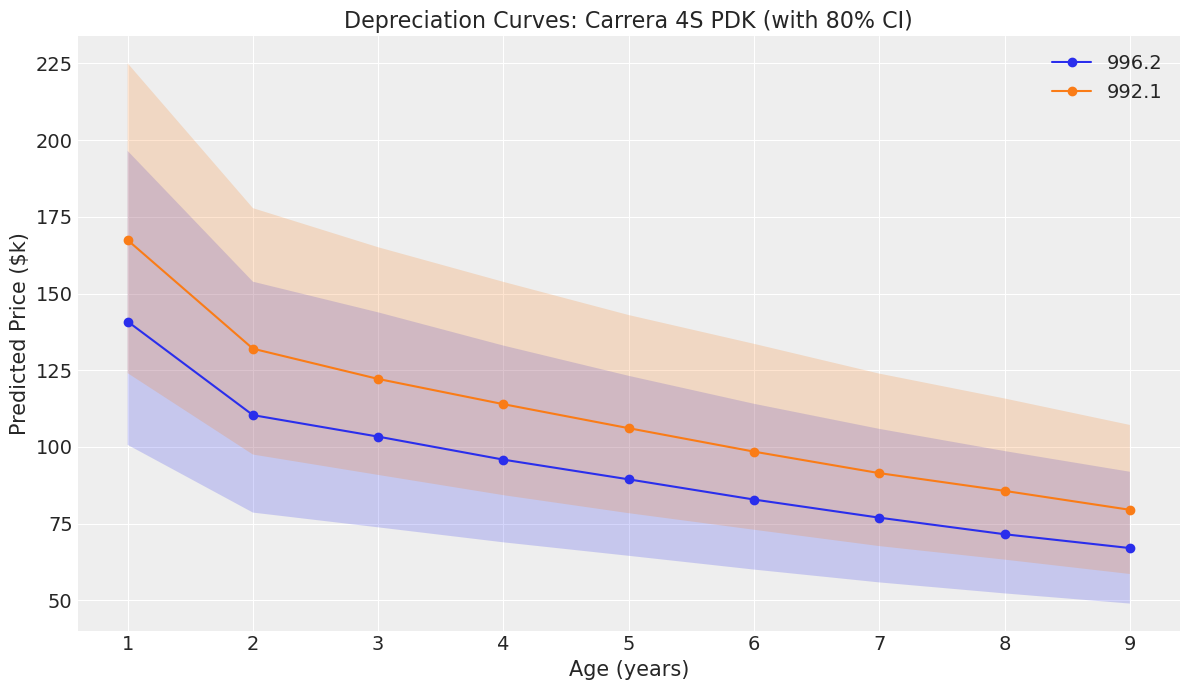

In [24]:
# Project prices for different generations over time
generations = ["996.2", "992.1"]
ages = range(1, 10)
base_year = 2020  # Approximate mid-point for 992.1

fig, ax = plt.subplots(figsize=(12, 7))

for gen in generations:
    medians = []
    ci_lows = []
    ci_highs = []

    for age in ages:
        pred_dep = predict_price(
            model=model,
            idata=idata,
            generation=gen,
            trim="Carrera 4S",
            trim_tier="sport",
            transmission="PDK",
            trans_type="pdk",
            model_year=base_year,
            mileage=5000 * age,  # Assume 5k miles/year
            sale_year=base_year + age,
            mileage_mean=MILEAGE_MEAN,
            mileage_std=MILEAGE_STD,
        )
        medians.append(pred_dep["price"]["median"])
        ci_lows.append(pred_dep["price"]["ci_80"][0])
        ci_highs.append(pred_dep["price"]["ci_80"][1])

    ax.plot(list(ages), [m / 1000 for m in medians], label=gen, marker="o")
    ax.fill_between(
        list(ages),
        [l / 1000 for l in ci_lows],
        [h / 1000 for h in ci_highs],
        alpha=0.2,
    )

ax.set_xlabel("Age (years)")
ax.set_ylabel("Predicted Price ($k)")
ax.set_title("Depreciation Curves: Carrera 4S PDK (with 80% CI)")
ax.legend()
plt.tight_layout()
plt.show()

## Pure Age Depreciation (Mileage Held Constant at 40k)

How does price decline purely with calendar time, independent of miles driven?

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/1751848552.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


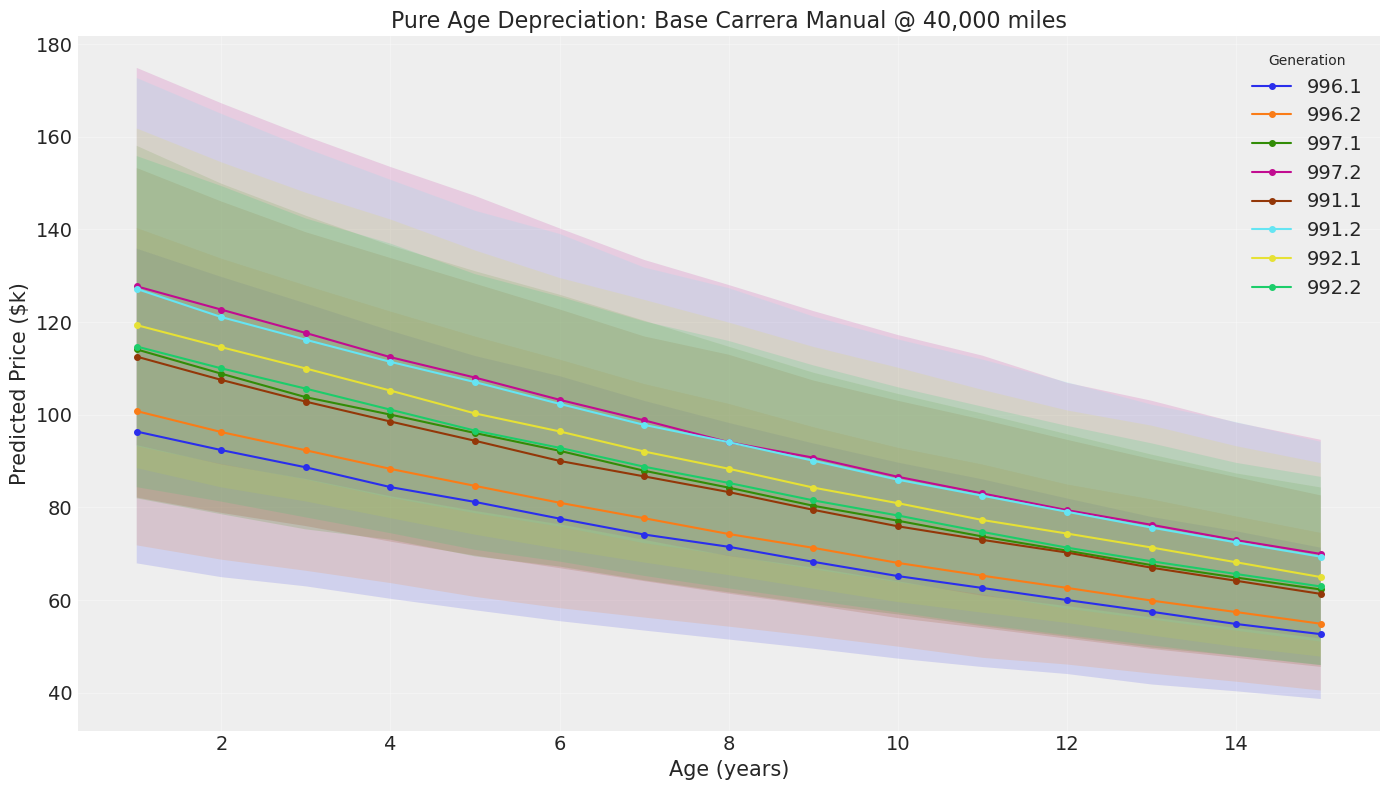


Average annual depreciation: 4.2% per year


In [25]:
# Pure age depreciation: hold mileage constant at 40k, vary age
# This isolates "calendar depreciation" from wear-based depreciation

FIXED_MILEAGE = 40000
ALL_GENS = ["996.1", "996.2", "997.1", "997.2", "991.1", "991.2", "992.1", "992.2"]
ages = range(1, 16)

fig, ax = plt.subplots(figsize=(14, 8))

for gen in ALL_GENS:
    medians = []
    ci_lows = []
    ci_highs = []

    for age in ages:
        pred_age = predict_price(
            model=model,
            idata=idata,
            generation=gen,
            trim="Carrera",
            trim_tier="base",
            transmission="Manual",
            trans_type="manual",
            model_year=2025 - age,
            mileage=FIXED_MILEAGE,
            sale_year=2025,
            mileage_mean=MILEAGE_MEAN,
            mileage_std=MILEAGE_STD,
        )
        medians.append(pred_age["price"]["median"])
        ci_lows.append(pred_age["price"]["ci_80"][0])
        ci_highs.append(pred_age["price"]["ci_80"][1])

    ax.plot(list(ages), [m / 1000 for m in medians], label=gen, marker="o", markersize=4)
    ax.fill_between(
        list(ages),
        [lo / 1000 for lo in ci_lows],
        [hi / 1000 for hi in ci_highs],
        alpha=0.15,
    )

ax.set_xlabel("Age (years)")
ax.set_ylabel("Predicted Price ($k)")
ax.set_title(f"Pure Age Depreciation: Base Carrera Manual @ {FIXED_MILEAGE:,} miles")
ax.legend(title="Generation", loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate annual depreciation rate from age coefficient
age_coef = idata.posterior["age"].mean().item()
annual_depreciation_pct = (1 - np.exp(age_coef)) * 100
print(f"\nAverage annual depreciation: {annual_depreciation_pct:.1f}% per year")

## Pure Mileage Depreciation (Age Held Constant at 5 Years)

How does price decline purely with miles driven, independent of calendar time?

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/1478149159.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


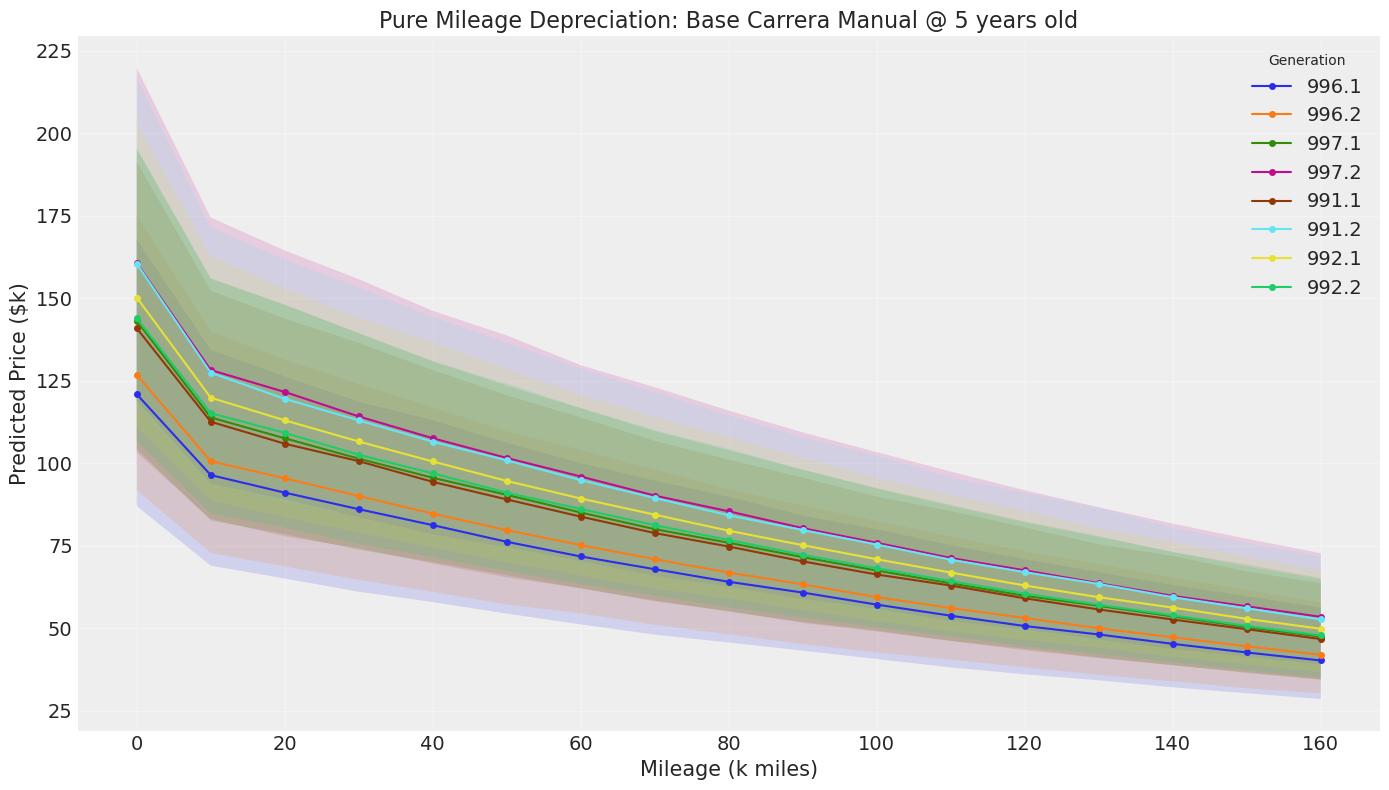

In [26]:
# Pure mileage depreciation: hold age constant at 5 years, vary mileage
# This isolates "wear depreciation" from calendar-based depreciation
import numpy as np

FIXED_AGE = 5
mileages = np.arange(0, 160001, 10000)  # 0 to 160k in 10k increments

fig, ax = plt.subplots(figsize=(14, 8))

for gen in ALL_GENS:
    medians = []
    ci_lows = []
    ci_highs = []

    for mileage in mileages:
        pred_mi = predict_price(
            model=model,
            idata=idata,
            generation=gen,
            trim="Carrera",
            trim_tier="base",
            transmission="Manual",
            trans_type="manual",
            model_year=2025 - FIXED_AGE,
            mileage=int(mileage),
            sale_year=2025,
            mileage_mean=MILEAGE_MEAN,
            mileage_std=MILEAGE_STD,
        )
        medians.append(pred_mi["price"]["median"])
        ci_lows.append(pred_mi["price"]["ci_80"][0])
        ci_highs.append(pred_mi["price"]["ci_80"][1])

    ax.plot(mileages / 1000, [m / 1000 for m in medians], label=gen, marker="o", markersize=4)
    ax.fill_between(
        mileages / 1000,
        [lo / 1000 for lo in ci_lows],
        [hi / 1000 for hi in ci_highs],
        alpha=0.15,
    )

ax.set_xlabel("Mileage (k miles)")
ax.set_ylabel("Predicted Price ($k)")
ax.set_title(f"Pure Mileage Depreciation: Base Carrera Manual @ {FIXED_AGE} years old")
ax.legend(title="Generation", loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Cost-per-Mile Analysis

How much does each mile cost in depreciation? The mileage coefficient is on log-price scale,
so the $/mile varies with car value - more expensive cars lose more dollars per mile.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/4056860952.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


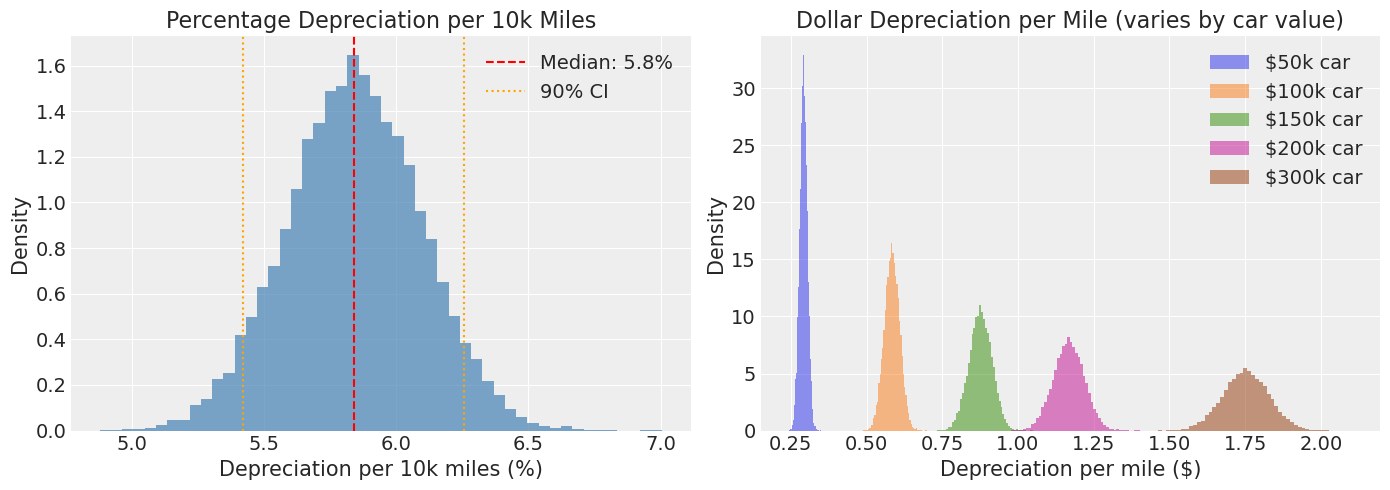

Cost-per-Mile Summary:
  Percentage per mile: 0.0006%
  Percentage per 10k miles: 5.8% [5.4%, 6.3%]

Dollar depreciation per mile by car value:
  $50k car: $0.29/mile [$0.27, $0.31]
  $100k car: $0.58/mile [$0.54, $0.63]
  $150k car: $0.88/mile [$0.81, $0.94]
  $200k car: $1.17/mile [$1.08, $1.25]
  $300k car: $1.75/mile [$1.63, $1.88]


In [27]:
# Cost per mile analysis
# The mileage coefficient β is on log-price scale
# d(log_price)/d(mileage) = β / MILEAGE_STD
# For a car at price P: d(price)/d(mileage) = P * β / MILEAGE_STD

mileage_coef_samples = idata.posterior["mileage_scaled"].values.flatten()

# Percentage depreciation per mile (constant across car values)
pct_per_mile = (1 - np.exp(mileage_coef_samples / MILEAGE_STD)) * 100

# Dollar depreciation per mile at different car values
car_values = [50000, 100000, 150000, 200000, 300000]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: percentage per 10k miles
ax = axes[0]
pct_per_10k = pct_per_mile * 10000
ax.hist(pct_per_10k, bins=50, alpha=0.7, density=True, color="steelblue")
ax.axvline(
    np.median(pct_per_10k),
    color="red",
    linestyle="--",
    label=f"Median: {np.median(pct_per_10k):.1f}%",
)
ax.axvline(np.percentile(pct_per_10k, 5), color="orange", linestyle=":", label="90% CI")
ax.axvline(np.percentile(pct_per_10k, 95), color="orange", linestyle=":")
ax.set_xlabel("Depreciation per 10k miles (%)")
ax.set_ylabel("Density")
ax.set_title("Percentage Depreciation per 10k Miles")
ax.legend()

# Right: dollar per mile at different car values
ax = axes[1]
for val in car_values:
    # Dollar depreciation = price * (1 - exp(β/std)) per mile
    dollar_per_mile = val * (1 - np.exp(mileage_coef_samples / MILEAGE_STD))
    ax.hist(dollar_per_mile, bins=50, alpha=0.5, density=True, label=f"${val / 1000:.0f}k car")

ax.set_xlabel("Depreciation per mile ($)")
ax.set_ylabel("Density")
ax.set_title("Dollar Depreciation per Mile (varies by car value)")
ax.legend()

plt.tight_layout()
plt.show()

# Summary table
print("Cost-per-Mile Summary:")
print(f"  Percentage per mile: {np.median(pct_per_mile):.4f}%")
print(
    f"  Percentage per 10k miles: {np.median(pct_per_10k):.1f}% [{np.percentile(pct_per_10k, 5):.1f}%, {np.percentile(pct_per_10k, 95):.1f}%]"
)
print("\nDollar depreciation per mile by car value:")
for val in car_values:
    dollar_per_mile = val * (1 - np.exp(mileage_coef_samples / MILEAGE_STD))
    print(
        f"  ${val / 1000:.0f}k car: ${np.median(dollar_per_mile):.2f}/mile [${np.percentile(dollar_per_mile, 5):.2f}, ${np.percentile(dollar_per_mile, 95):.2f}]"
    )

## Shrinkage Plot (Partial Pooling Visualization)

Hierarchical models "shrink" group estimates toward the grand mean, especially for groups with
less data. This plot compares raw group means (unpooled) with hierarchical estimates (partial pooling).

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/4258887752.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_gen_means = df.groupby("generation")["log_price"].mean()
/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/4258887752.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gen_counts = df.groupby("generation").size()
/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/4258887752.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

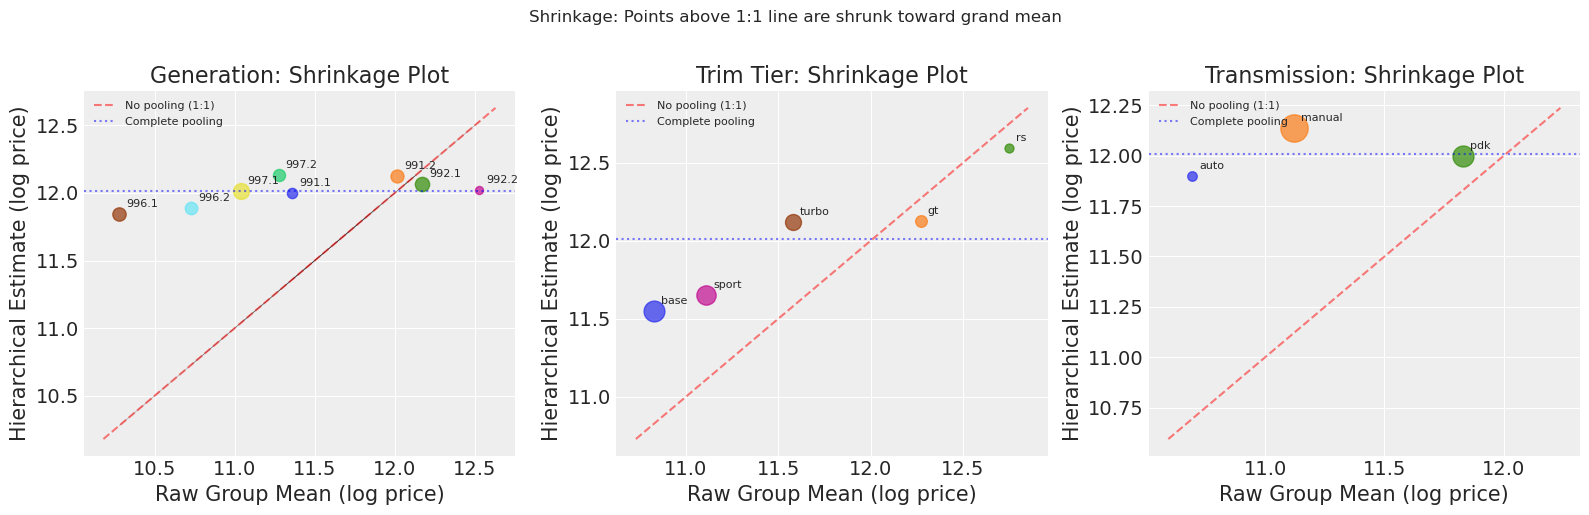

Interpretation: Points close to the 1:1 line have little shrinkage (large groups).
Points pulled toward the blue line are shrunk more (smaller groups or extreme values).


In [28]:
# Shrinkage plot: compare raw means to hierarchical estimates
# This shows how partial pooling works

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Grand mean (intercept)
grand_mean = idata.posterior["Intercept"].mean().item()

# --- Generation ---
ax = axes[0]
raw_gen_means = df.groupby("generation")["log_price"].mean()
gen_counts = df.groupby("generation").size()

# Hierarchical means: grand mean + generation effect
gen_effects = {}
for gen in raw_gen_means.index:
    effect = idata.posterior[f"1|generation"].sel({"generation__factor_dim": gen}).mean().item()
    gen_effects[gen] = grand_mean + effect

# Plot
for gen in raw_gen_means.index:
    raw = raw_gen_means[gen]
    hier = gen_effects[gen]
    count = gen_counts[gen]
    ax.scatter(raw, hier, s=count / 2, alpha=0.7)
    ax.annotate(gen, (raw, hier), fontsize=8, xytext=(5, 5), textcoords="offset points")
    ax.plot([raw, hier], [raw, hier], "k-", alpha=0.3, lw=0.5)  # reference line segment

# 1:1 line (no shrinkage)
lims = [
    min(raw_gen_means.min(), min(gen_effects.values())) - 0.1,
    max(raw_gen_means.max(), max(gen_effects.values())) + 0.1,
]
ax.plot(lims, lims, "r--", alpha=0.5, label="No pooling (1:1)")
ax.axhline(grand_mean, color="blue", linestyle=":", alpha=0.5, label="Complete pooling")
ax.set_xlabel("Raw Group Mean (log price)")
ax.set_ylabel("Hierarchical Estimate (log price)")
ax.set_title("Generation: Shrinkage Plot")
ax.legend(fontsize=8)

# --- Trim Tier ---
ax = axes[1]
raw_trim_means = df.groupby("trim_tier")["log_price"].mean()
trim_counts = df.groupby("trim_tier").size()

trim_effects = {}
for trim in raw_trim_means.index:
    effect = idata.posterior["1|trim_tier"].sel({"trim_tier__factor_dim": trim}).mean().item()
    trim_effects[trim] = grand_mean + effect

for trim in raw_trim_means.index:
    raw = raw_trim_means[trim]
    hier = trim_effects[trim]
    count = trim_counts[trim]
    ax.scatter(raw, hier, s=count / 2, alpha=0.7)
    ax.annotate(trim, (raw, hier), fontsize=8, xytext=(5, 5), textcoords="offset points")

lims = [
    min(raw_trim_means.min(), min(trim_effects.values())) - 0.1,
    max(raw_trim_means.max(), max(trim_effects.values())) + 0.1,
]
ax.plot(lims, lims, "r--", alpha=0.5, label="No pooling (1:1)")
ax.axhline(grand_mean, color="blue", linestyle=":", alpha=0.5, label="Complete pooling")
ax.set_xlabel("Raw Group Mean (log price)")
ax.set_ylabel("Hierarchical Estimate (log price)")
ax.set_title("Trim Tier: Shrinkage Plot")
ax.legend(fontsize=8)

# --- Transmission Type ---
ax = axes[2]
raw_trans_means = df.groupby("trans_type")["log_price"].mean()
trans_counts = df.groupby("trans_type").size()

trans_effects = {}
for trans in raw_trans_means.index:
    effect = idata.posterior["1|trans_type"].sel({"trans_type__factor_dim": trans}).mean().item()
    trans_effects[trans] = grand_mean + effect

for trans in raw_trans_means.index:
    raw = raw_trans_means[trans]
    hier = trans_effects[trans]
    count = trans_counts[trans]
    ax.scatter(raw, hier, s=count / 2, alpha=0.7)
    ax.annotate(trans, (raw, hier), fontsize=8, xytext=(5, 5), textcoords="offset points")

lims = [
    min(raw_trans_means.min(), min(trans_effects.values())) - 0.1,
    max(raw_trans_means.max(), max(trans_effects.values())) + 0.1,
]
ax.plot(lims, lims, "r--", alpha=0.5, label="No pooling (1:1)")
ax.axhline(grand_mean, color="blue", linestyle=":", alpha=0.5, label="Complete pooling")
ax.set_xlabel("Raw Group Mean (log price)")
ax.set_ylabel("Hierarchical Estimate (log price)")
ax.set_title("Transmission: Shrinkage Plot")
ax.legend(fontsize=8)

plt.suptitle("Shrinkage: Points above 1:1 line are shrunk toward grand mean", y=1.02)
plt.tight_layout()
plt.show()

print("Interpretation: Points close to the 1:1 line have little shrinkage (large groups).")
print("Points pulled toward the blue line are shrunk more (smaller groups or extreme values).")

## Shrinkage on Regression Lines

Compares unpooled OLS (dashed) vs hierarchical (solid) fits per generation.
Sparse generations show more shrinkage toward the global trend.

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gen_counts = df.groupby("generation").size().sort_values()
/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:90: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


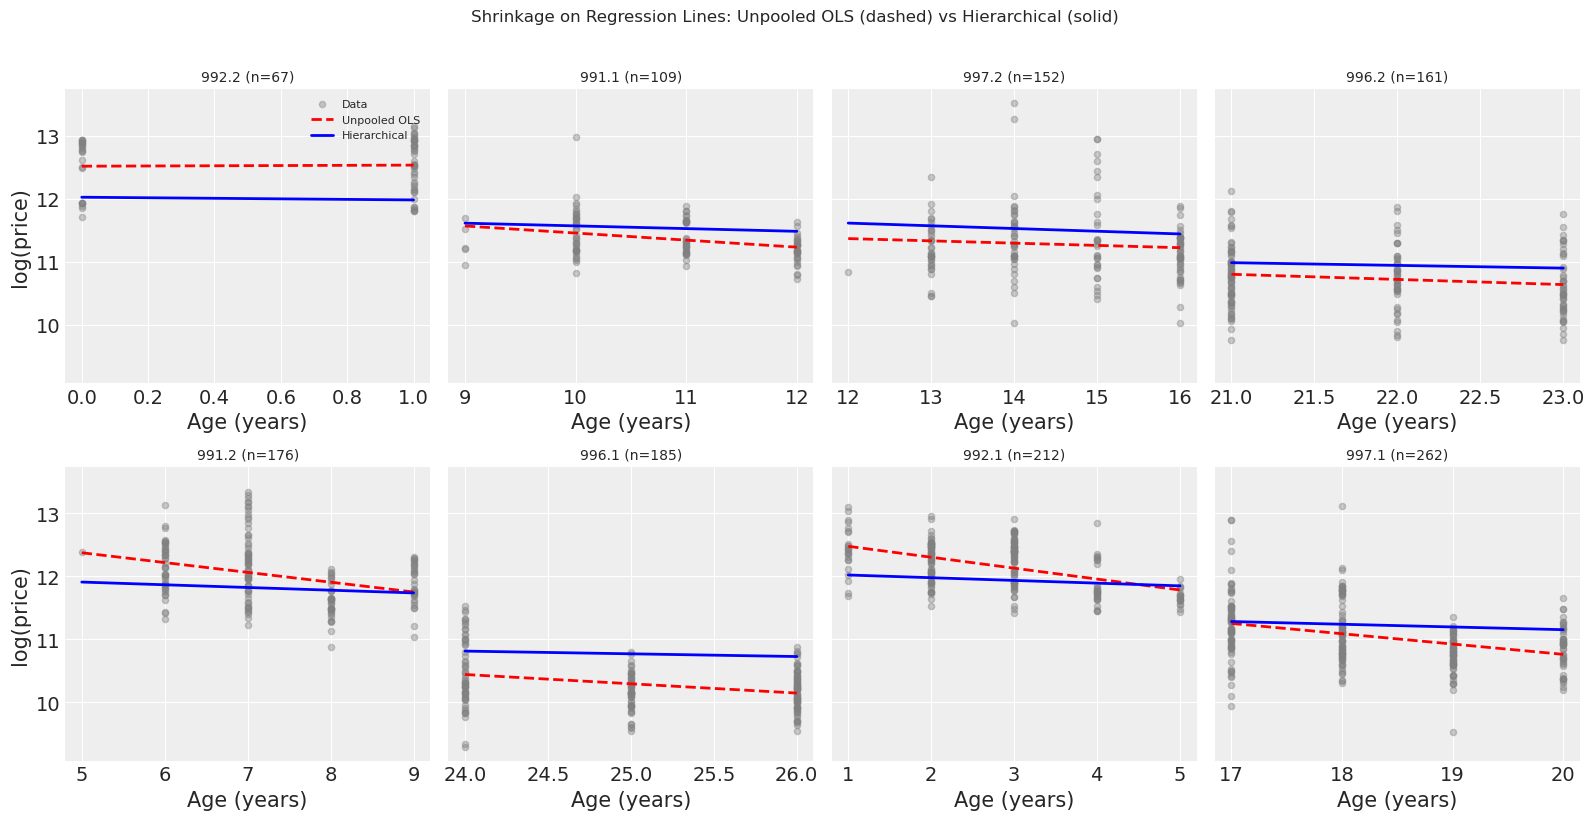

,n,ols_intercept,hier_intercept,shrinkage
generation,,,,
992.2,67,12.516992,12.024224,-0.492767
991.1,109,12.577844,12.000052,-0.577792
997.2,152,11.800541,12.130814,0.330273
996.2,161,12.516934,11.889928,-0.627006
991.2,176,13.153366,12.123310,-1.030056
996.1,185,13.983346,11.845834,-2.137513
992.1,212,12.649398,12.062885,-0.586513
997.1,262,14.034888,12.013584,-2.021304


In [29]:
fig, shrinkage_df = plot_shrinkage_regression(df, idata)
plt.show()
display(shrinkage_df.set_index("generation"))

## Prior vs Posterior Comparison

Shows how the data updated our prior beliefs. Narrower, shifted posteriors = informative data.

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/visualization/model_viz.py:173: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


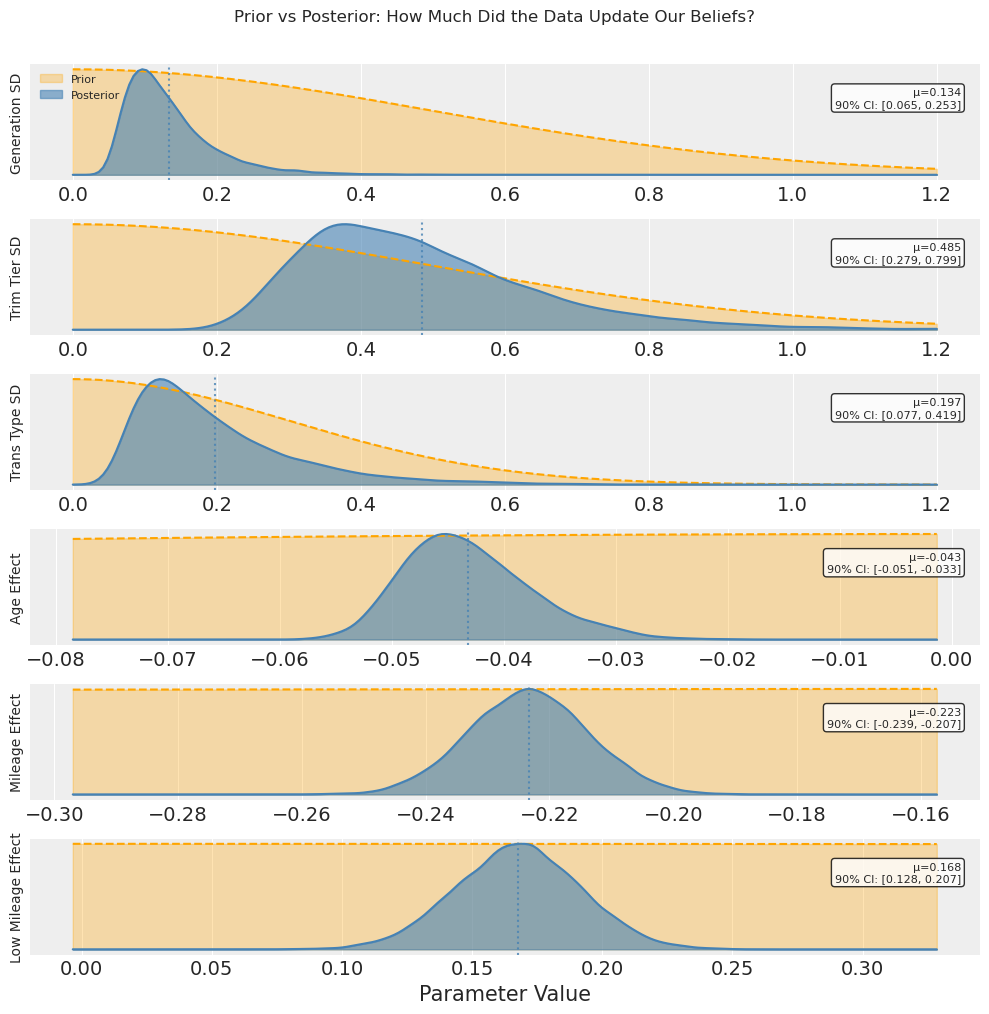

In [30]:
fig = plot_prior_posterior(idata)
plt.show()

## Dollar-Denominated Premiums

Convert random effects from log-scale to dollar amounts. Since effects are multiplicative,
we show premiums for a reference car (median price ~$80k).

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_48188/2125176516.py:82: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


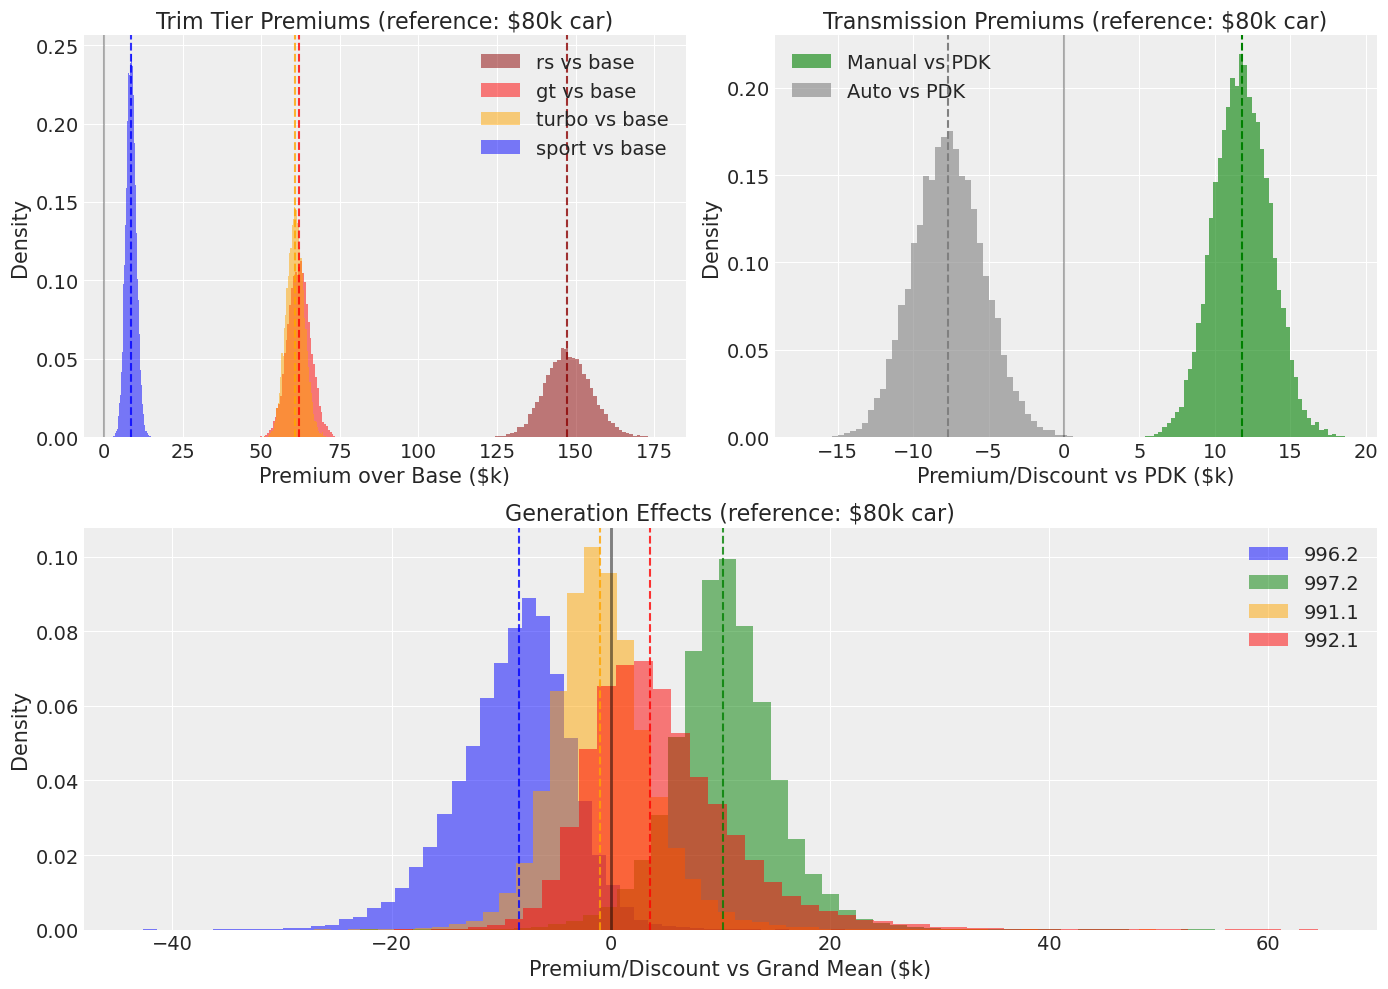

Premium Summary (at $80k reference price):

Trim Tier vs Base:
  sport: $+8,555 [$+5,920, $+11,312]
  turbo: $+60,809 [$+56,218, $+65,413]
  gt: $+62,008 [$+56,159, $+68,044]
  rs: $+147,365 [$+135,804, $+159,980]

Transmission vs PDK:
  Manual: $+11,777 [$+8,749, $+14,869]
  Auto:   $-7,682 [$-11,414, $-3,816]

Generation vs Grand Mean:
  996.2: $-8,407 [$-17,999, $-1,363]
  997.2: $+10,282 [$+2,605, $+18,216]
  991.1: $-1,023 [$-7,426, $+6,975]
  992.1: $+3,546 [$-4,159, $+16,655]


In [31]:
# Dollar premiums: convert log-scale effects to real dollars
# For a reference car at median price, compute the dollar difference

REFERENCE_PRICE = 80000  # Median price from EDA

fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# --- Trim Tier Premiums (top left) ---
ax = fig.add_subplot(gs[0, 0])
base_effect = idata.posterior["1|trim_tier"].sel({"trim_tier__factor_dim": "base"}).values.flatten()

for tier, color in [("rs", "darkred"), ("gt", "red"), ("turbo", "orange"), ("sport", "blue")]:
    tier_effect = (
        idata.posterior["1|trim_tier"].sel({"trim_tier__factor_dim": tier}).values.flatten()
    )
    premium_dollar = REFERENCE_PRICE * (np.exp(tier_effect - base_effect) - 1)

    ax.hist(
        premium_dollar / 1000,
        bins=50,
        alpha=0.5,
        label=f"{tier} vs base",
        color=color,
        density=True,
    )
    ax.axvline(np.median(premium_dollar) / 1000, color=color, linestyle="--", alpha=0.8)

ax.axvline(0, color="black", linestyle="-", alpha=0.3)
ax.set_xlabel("Premium over Base ($k)")
ax.set_ylabel("Density")
ax.set_title(f"Trim Tier Premiums (reference: ${REFERENCE_PRICE / 1000:.0f}k car)")
ax.legend()

# --- Transmission Premiums (top right) ---
ax = fig.add_subplot(gs[0, 1])
pdk_effect = idata.posterior["1|trans_type"].sel({"trans_type__factor_dim": "pdk"}).values.flatten()
manual_effect = (
    idata.posterior["1|trans_type"].sel({"trans_type__factor_dim": "manual"}).values.flatten()
)
auto_effect = (
    idata.posterior["1|trans_type"].sel({"trans_type__factor_dim": "auto"}).values.flatten()
)

manual_premium = REFERENCE_PRICE * (np.exp(manual_effect - pdk_effect) - 1)
ax.hist(
    manual_premium / 1000, bins=50, alpha=0.6, label="Manual vs PDK", color="green", density=True
)
ax.axvline(np.median(manual_premium) / 1000, color="green", linestyle="--")

auto_discount = REFERENCE_PRICE * (np.exp(auto_effect - pdk_effect) - 1)
ax.hist(auto_discount / 1000, bins=50, alpha=0.6, label="Auto vs PDK", color="gray", density=True)
ax.axvline(np.median(auto_discount) / 1000, color="gray", linestyle="--")

ax.axvline(0, color="black", linestyle="-", alpha=0.3)
ax.set_xlabel("Premium/Discount vs PDK ($k)")
ax.set_ylabel("Density")
ax.set_title(f"Transmission Premiums (reference: ${REFERENCE_PRICE / 1000:.0f}k car)")
ax.legend()

# --- Generation Effects (bottom row, spanning both columns) ---
ax = fig.add_subplot(gs[1, :])
selected_gens = ["996.2", "997.2", "991.1", "992.1"]
gen_colors = {"996.2": "blue", "997.2": "green", "991.1": "orange", "992.1": "red"}

for gen in selected_gens:
    gen_effect = (
        idata.posterior["1|generation"].sel({"generation__factor_dim": gen}).values.flatten()
    )
    premium_dollar = REFERENCE_PRICE * (np.exp(gen_effect) - 1)
    ax.hist(
        premium_dollar / 1000, bins=50, alpha=0.5, label=gen, color=gen_colors[gen], density=True
    )
    ax.axvline(np.median(premium_dollar) / 1000, color=gen_colors[gen], linestyle="--", alpha=0.8)

ax.axvline(0, color="black", linestyle="-", alpha=0.5, lw=2)
ax.set_xlabel("Premium/Discount vs Grand Mean ($k)")
ax.set_ylabel("Density")
ax.set_title(f"Generation Effects (reference: ${REFERENCE_PRICE / 1000:.0f}k car)")
ax.legend()

plt.tight_layout()
plt.show()

# Summary statistics
print(f"Premium Summary (at ${REFERENCE_PRICE / 1000:.0f}k reference price):")
print("\nTrim Tier vs Base:")
for tier in ["sport", "turbo", "gt", "rs"]:
    tier_effect = (
        idata.posterior["1|trim_tier"].sel({"trim_tier__factor_dim": tier}).values.flatten()
    )
    premium = REFERENCE_PRICE * (np.exp(tier_effect - base_effect) - 1)
    print(
        f"  {tier}: ${np.median(premium):+,.0f} [${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
    )

print("\nTransmission vs PDK:")
print(
    f"  Manual: ${np.median(manual_premium):+,.0f} [${np.percentile(manual_premium, 5):+,.0f}, ${np.percentile(manual_premium, 95):+,.0f}]"
)
print(
    f"  Auto:   ${np.median(auto_discount):+,.0f} [${np.percentile(auto_discount, 5):+,.0f}, ${np.percentile(auto_discount, 95):+,.0f}]"
)

print("\nGeneration vs Grand Mean:")
for gen in selected_gens:
    gen_effect = (
        idata.posterior["1|generation"].sel({"generation__factor_dim": gen}).values.flatten()
    )
    premium = REFERENCE_PRICE * (np.exp(gen_effect) - 1)
    print(
        f"  {gen}: ${np.median(premium):+,.0f} [${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
    )

## Residual Analysis: Where is the Model Missing Information?

Cars selling above/below prediction likely have attributes the model doesn't capture:
- **Over prediction** (actual < predicted): Condition issues, undesirable options, salvage title
- **Under prediction** (actual > predicted): PTS colors, rare options, low production, exceptional condition

This helps identify what information we're missing, not necessarily "deals".

In [32]:
# Generate predictions for all observations
# Note: kind="response_params" replaces deprecated "mean"
model.predict(idata, data=df, kind="response_params", inplace=True)

# Extract posterior mean predictions (stored as 'mu' in posterior)
predicted_log_price = idata.posterior["mu"].mean(dim=["chain", "draw"]).values

# Create residual dataframe
df_resid = df.copy()
df_resid["predicted_log_price"] = predicted_log_price
df_resid["residual"] = df_resid["log_price"] - df_resid["predicted_log_price"]
df_resid["pct_diff"] = (np.exp(df_resid["residual"]) - 1) * 100  # % above/below prediction
df_resid["predicted_price"] = np.exp(df_resid["predicted_log_price"])

print(f"Residual summary:")
print(f"  Mean: {df_resid['residual'].mean():.4f} (should be ~0)")
print(f"  Std:  {df_resid['residual'].std():.4f}")
print(f"  Min:  {df_resid['residual'].min():.4f} ({df_resid['pct_diff'].min():.1f}%)")
print(f"  Max:  {df_resid['residual'].max():.4f} ({df_resid['pct_diff'].max():.1f}%)")

Residual summary:
  Mean: -0.0000 (should be ~0)
  Std:  0.2321
  Min:  -1.0829 (-66.1%)
  Max:  1.5748 (383.0%)


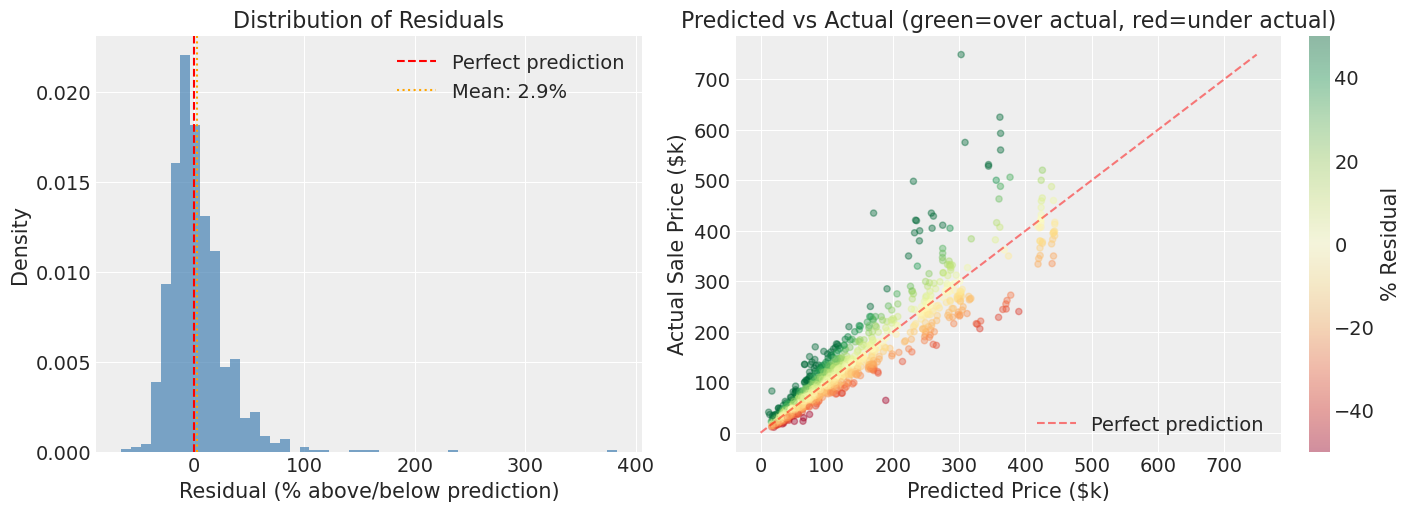

In [33]:
# Residual visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram of residuals (should be ~normal)
ax = axes[0]
ax.hist(df_resid["pct_diff"], bins=50, alpha=0.7, density=True, color="steelblue")
ax.axvline(0, color="red", linestyle="--", label="Perfect prediction")
ax.axvline(
    df_resid["pct_diff"].mean(),
    color="orange",
    linestyle=":",
    label=f"Mean: {df_resid['pct_diff'].mean():.1f}%",
)
ax.set_xlabel("Residual (% above/below prediction)")
ax.set_ylabel("Density")
ax.set_title("Distribution of Residuals")
ax.legend()

# Right: Predicted vs Actual scatter
ax = axes[1]
ax.scatter(
    df_resid["predicted_price"] / 1000,
    df_resid["sale_price"] / 1000,
    alpha=0.4,
    s=20,
    c=df_resid["pct_diff"],
    cmap="RdYlGn",
    vmin=-50,
    vmax=50,
)
# 1:1 line
max_price = max(df_resid["predicted_price"].max(), df_resid["sale_price"].max()) / 1000
ax.plot([0, max_price], [0, max_price], "r--", alpha=0.5, label="Perfect prediction")
ax.set_xlabel("Predicted Price ($k)")
ax.set_ylabel("Actual Sale Price ($k)")
ax.set_title("Predicted vs Actual (green=over actual, red=under actual)")
ax.legend()
plt.colorbar(ax.collections[0], ax=ax, label="% Residual")

# plt.tight_layout()
plt.show()

In [34]:
# Top outliers: what information is the model missing?

# Columns to display
display_cols = [
    "title_raw",
    "generation",
    "trim",
    "transmission",
    "mileage",
    "sale_price",
    "predicted_price",
    "pct_diff",
    "listing_url",
]


# Format for display
def format_outliers(df_out):
    df_display = df_out[display_cols].copy()
    df_display["sale_price"] = df_display["sale_price"].apply(lambda x: f"${x:,.0f}")
    df_display["predicted_price"] = df_display["predicted_price"].apply(lambda x: f"${x:,.0f}")
    df_display["pct_diff"] = df_display["pct_diff"].apply(lambda x: f"{x:+.1f}%")
    df_display["mileage"] = df_display["mileage"].apply(lambda x: f"{x:,.0f}")
    return df_display


print("=" * 80)
print("MODEL UNDER-PREDICTED (sold ABOVE prediction)")
print("Likely: PTS colors, rare options, low production, exceptional condition")
print("=" * 80)
top_under = df_resid.nlargest(10, "pct_diff")
display(format_outliers(top_under))

print("\n" + "=" * 80)
print("MODEL OVER-PREDICTED (sold BELOW prediction)")
print("Likely: Condition issues, undesirable options, salvage title, high-mile examples")
print("=" * 80)
top_over = df_resid.nsmallest(10, "pct_diff")
display(format_outliers(top_over))

MODEL UNDER-PREDICTED (sold ABOVE prediction)
Likely: PTS colors, rare options, low production, exceptional condition


,title_raw,generation,trim,transmission,mileage,sale_price,predicted_price,pct_diff,listing_url
329,Safari-Style 2001 Porsche 911 Carrera 4 Coupe ...,996.1,Carrera 4,Manual,"166,000","$82,500","$17,081",+383.0%,https://bringatrailer.com/listing/2001-porsche...
29,Modified 1999 Porsche 911 Carrera Coupe 6-Speed,996.1,Carrera,Manual,"208,000","$40,500","$12,261",+230.3%,https://bringatrailer.com/listing/1999-porsche...
279,LS3-Powered 1999 Porsche 911 Carrera 4 Coupe 6...,996.1,Carrera 4,Manual,"187,000","$35,911","$13,860",+159.1%,https://bringatrailer.com/listing/1999-porsche...
1160,Jerry Seinfeld’s 2014 Porsche 911 50th Anniver...,991.1,Turbo S,PDK,"3,700","$435,000","$170,649",+154.9%,https://bringatrailer.com/listing/2014-porsche...
785,"4,000-Mile 2011 Porsche 911 GT3 RS 4.0",997.2,GT3 RS,Manual,"4,000","$749,000","$302,807",+147.4%,https://bringatrailer.com/listing/2011-porsche...
463,868-Mile 2007 Porsche 911 GT3 RS,997.1,GT3 RS,Manual,868,"$498,000","$230,806",+115.8%,https://bringatrailer.com/listing/2007-porsche...
896,2016 Porsche 911 Carrera GTS Club Coupe,991.2,Carrera,PDK,"31,000","$170,000","$82,575",+105.9%,https://bringatrailer.com/listing/2016-porsche...
560,2011 Porsche 911 Carrera GTS Coupe 6-Speed,997.2,Carrera,Manual,"56,000","$135,500","$66,472",+103.8%,https://bringatrailer.com/listing/2011-porsche...
455,45k-Mile 2012 Porsche 911 Carrera GTS 6-Speed,997.2,Carrera,Manual,"45,000","$150,777","$74,007",+103.7%,https://bringatrailer.com/listing/2012-porsche...
277,RWD-Converted 2003 Porsche 911 Carrera 4S Coup...,996.2,Carrera 4S,Manual,"1,400","$135,000","$66,607",+102.7%,https://bringatrailer.com/listing/2003-porsche...



MODEL OVER-PREDICTED (sold BELOW prediction)
Likely: Condition issues, undesirable options, salvage title, high-mile examples


,title_raw,generation,trim,transmission,mileage,sale_price,predicted_price,pct_diff,listing_url
714,2011 Porsche 911 GT3 Cup,997.2,GT3,Manual,"4,000","$64,000","$189,002",-66.1%,https://bringatrailer.com/listing/2011-porsche...
418,4.0L-Powered 2009 Porsche 911 Carrera S Coupe ...,997.2,Carrera S,Manual,"65,000","$22,750","$64,040",-64.5%,https://bringatrailer.com/listing/2009-porsche...
759,2011 Porsche 911 Carrera 4S Cabriolet,997.2,Carrera 4S,PDK,"95,000","$22,500","$51,076",-55.9%,https://bringatrailer.com/listing/2011-porsche...
693,2006 Porsche 911 Carrera S Coupe 6-Speed Race ...,997.1,Carrera S,Manual,"20,000","$29,500","$65,081",-54.7%,https://bringatrailer.com/listing/2006-porsche...
442,45k-Mile 2012 Porsche 911 Carrera Cabriolet Bl...,997.2,Carrera,Manual,"45,000","$36,250","$74,007",-51.0%,https://bringatrailer.com/listing/2012-porsche...
45,2004 Porsche 911 Carrera 4S Cabriolet,996.2,Carrera 4S,Manual,"100,000","$17,250","$33,066",-47.8%,https://bringatrailer.com/listing/2004-porsche...
189,2001 Porsche 911 Carrera Cabriolet 6-Speed,996.1,Carrera,Manual,"138,000","$10,750","$20,115",-46.6%,https://bringatrailer.com/listing/2001-porsche...
146,Original-Owner 2002 Porsche 911 Carrera 4 Cabr...,996.2,Carrera 4,Manual,"58,000","$19,049","$35,019",-45.6%,https://bringatrailer.com/listing/2002-porsche...
26,38k-Mile 2004 Porsche 911 Carrera Cabriolet 6-...,996.2,Carrera,Manual,"38,000","$24,500","$42,905",-42.9%,https://bringatrailer.com/listing/2004-porsche...
183,1999 Porsche 911 Carrera Cabriolet 6-Speed,996.1,Carrera,Manual,"71,000","$16,250","$27,288",-40.5%,https://bringatrailer.com/listing/1999-porsche...


## Save Model Artifacts

In [35]:
# Save inference data for later use
# idata.to_netcdf(DATA_DIR / "processed" / "model_idata.nc")
# print("Saved inference data")